In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import copy
import os

batch_size = 128
learning_rate = 1e-3

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = 'path = "/content/drive/My Drive/spectrogram';
train_path='/content/drive/My Drive/spectrogram/Training';
test_path ='/content/drive/My Drive/spectrogram/Validation';
path

'path = "/content/drive/My Drive/spectrogram'

images-size: torch.Size([128, 3, 224, 320])
out-size: torch.Size([3, 3618, 2578])


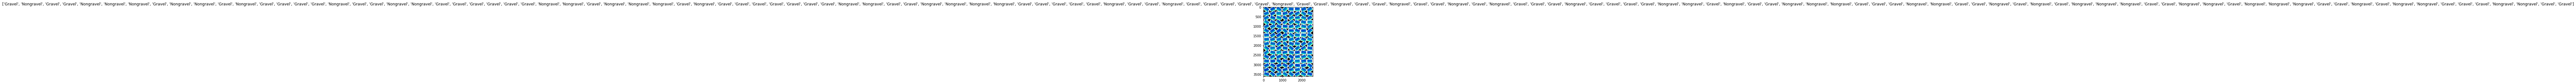

In [ ]:
transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    #transforms.CenterCrop(224),
    transforms.RandomRotation(degrees=40),

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # three channels RGB 
    ])

train_dataset = datasets.ImageFolder(root=train_path, transform=transforms)
test_dataset = datasets.ImageFolder(root= test_path, transform=transforms)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def imshow(inp, title=None):
    
    inp = inp.cpu() if device else inp
    inp = inp.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
   
    #std = np.array([0.229, 0.224, 0.225])
    std = np.array([0.6, 0.6, 0.6])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
images, labels = next(iter(train_dataloader)) 
print("images-size:", images.shape)

out = torchvision.utils.make_grid(images)
print("out-size:", out.shape)

imshow(out, title=[train_dataset.classes[x] for x in labels])

In [ ]:
net = models.googlenet(pretrained=True)
#net = net.cuda() if device else net
net

In [ ]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.01)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)


def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 2)
num_ftrs

1024

In [ ]:
n_epochs = 100
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
       # data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (test_dataloader):
            #data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'resnet.pt')
            print('Improvement-Detected, save-model')
    net.train()

Epoch 1

Epoch [1/100], Step [0/2], Loss: 0.6776

train-loss: 0.7602, train-acc: 54.4974
validation loss: 0.7156, validation acc: 56.2500

Improvement-Detected, save-model
Epoch 2

Epoch [2/100], Step [0/2], Loss: 0.7044

train-loss: 0.7146, train-acc: 59.7884
validation loss: 0.7329, validation acc: 56.2500

Epoch 3

Epoch [3/100], Step [0/2], Loss: 0.3950

train-loss: 0.5860, train-acc: 88.3598
validation loss: 0.9612, validation acc: 56.2500

Epoch 4

Epoch [4/100], Step [0/2], Loss: 0.2012

train-loss: 0.4868, train-acc: 92.5926
validation loss: 1.3904, validation acc: 56.2500

Epoch 5

Epoch [5/100], Step [0/2], Loss: 0.1393

train-loss: 0.4130, train-acc: 94.7090
validation loss: 1.8017, validation acc: 56.2500

Epoch 6

Epoch [6/100], Step [0/2], Loss: 0.1598

train-loss: 0.3623, train-acc: 95.2381
validation loss: 2.1376, validation acc: 56.2500

Epoch 7

Epoch [7/100], Step [0/2], Loss: 0.2121

train-loss: 0.3278, train-acc: 93.1217
validation loss: 2.1203, validation acc: 62.

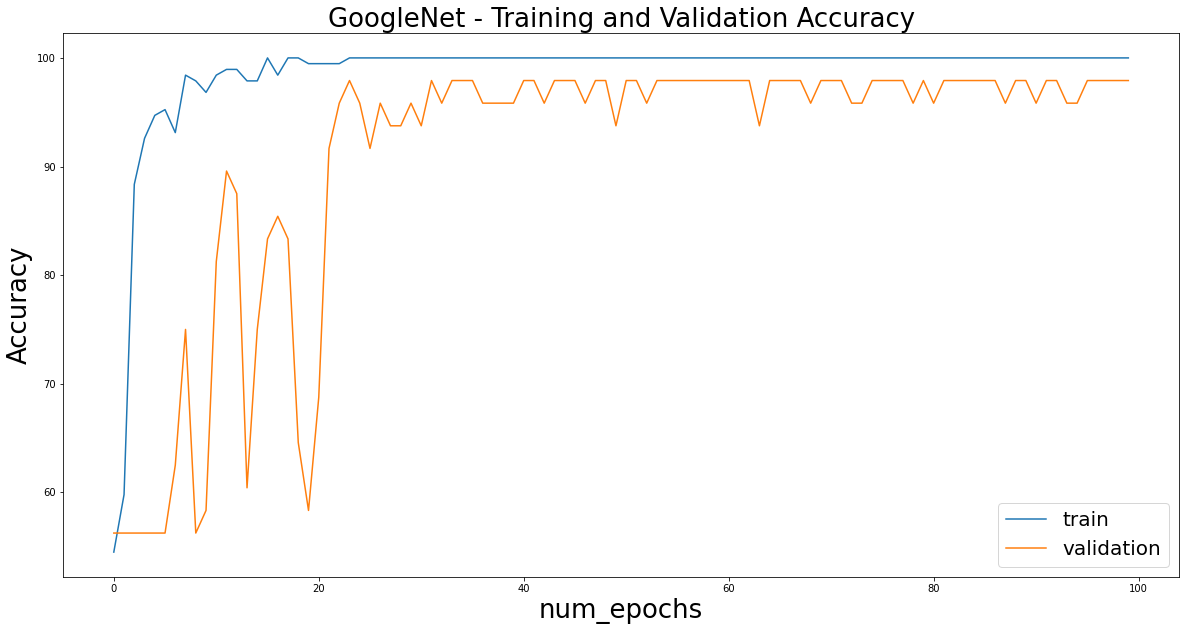

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("GoogleNet - Training and Validation Accuracy",fontdict={'fontsize': 26, 'fontweight': 'medium'})
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=26)
plt.ylabel('Accuracy', fontsize=26)
plt.legend(loc='best',fontsize=20)

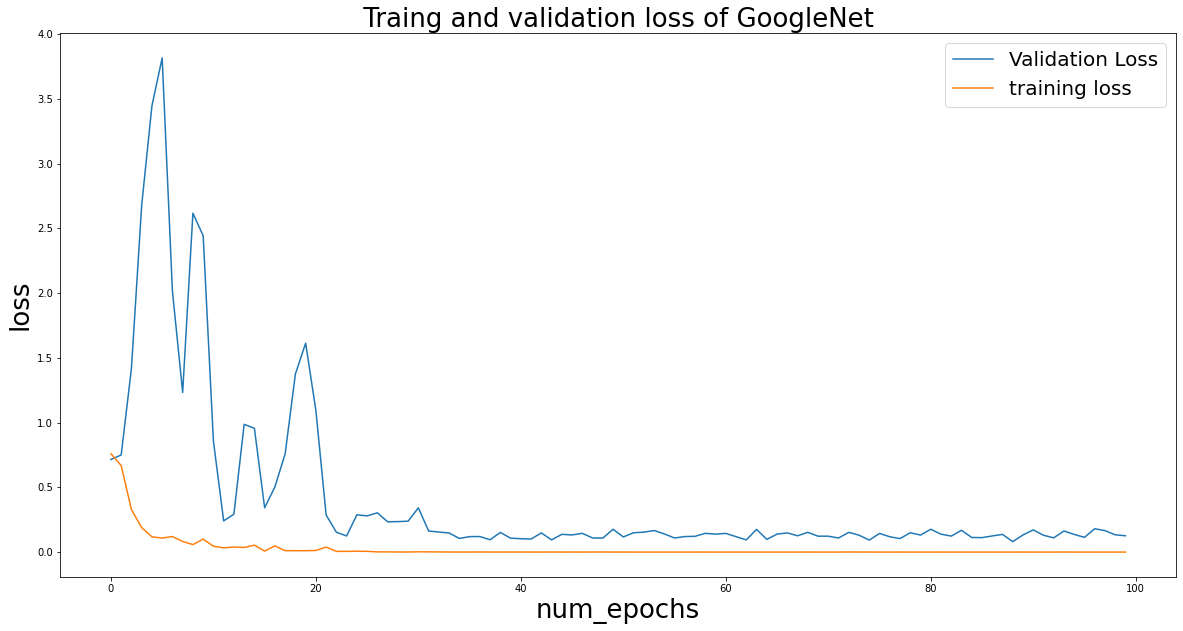

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title(" Traing and validation loss of GoogleNet ",fontdict={'fontsize': 26, 'fontweight': 'medium'})

plt.plot(val_loss, label='Validation Loss',)
plt.plot(train_loss, label = 'training loss')

plt.xlabel('num_epochs', fontsize=26)
plt.ylabel('loss', fontsize=26)
plt.legend(loc='best',fontsize=20)